In [ ]:
##Import Required Modules

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
##Import data set

In [51]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 
CHANNELS=3
EPOCHS=10

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [9]:
len(dataset)

68

In [ ]:
##Visualize some of the images from our dataset

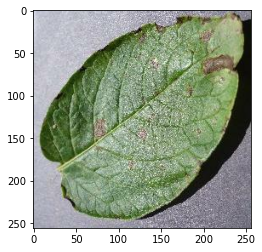

In [17]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

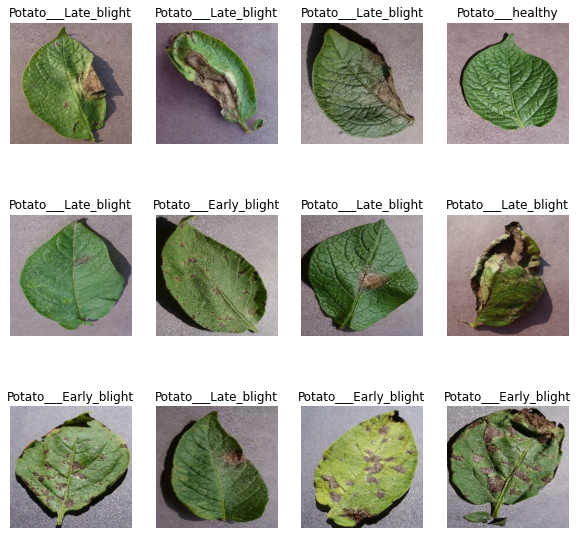

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
##Function to Split Dataset
##Dataset should be bifurcated into 3 subsets, namely:
##Training: Dataset to be used while training
##Validation: Dataset to be tested against while training
##Test: Dataset to be tested against after we trained a model

In [23]:
len(dataset)

68

In [24]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [25]:
train_ds = dataset.take(54)
len(train_ds)

54

In [26]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [27]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [28]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [32]:
len(train_ds)


54

In [33]:
len(val_ds)


6

In [35]:
##Cache, Shuffle, and Prefetch the Dataset


In [36]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
##Building the Model
##Creating a Layer for Resizing and Normalization

In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [39]:
##Data Augmentation

In [40]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [41]:
##Applying Data Augmentation to Train Dataset

In [42]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [43]:
##Model Architecture

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [47]:
##Compiling the Model


In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 136s 3s/step - loss: 0.8121 - accuracy: 0.6389 - val_loss: 0.6089 - val_accuracy: 0.7188
Epoch 2/10
54/54 [==============================] - 132s 2s/step - loss: 0.5994 - accuracy: 0.7471 - val_loss: 0.4941 - val_accuracy: 0.7760
Epoch 3/10
54/54 [==============================] - 132s 2s/step - loss: 0.4441 - accuracy: 0.8183 - val_loss: 0.3835 - val_accuracy: 0.8333
Epoch 4/10
54/54 [==============================] - 141s 3s/step - loss: 0.3547 - accuracy: 0.8634 - val_loss: 0.3321 - val_accuracy: 0.8906
Epoch 5/10
54/54 [==============================] - 131s 2s/step - loss: 0.2834 - accuracy: 0.8814 - val_loss: 0.2365 - val_accuracy: 0.9062
Epoch 6/10
54/54 [==============================] - 121s 2s/step - loss: 0.2471 - accuracy: 0.8999 - val_loss: 0.2156 - val_accuracy: 0.9062
Epoch 7/10
54/54 [==============================] - 127s 2s/step - loss: 0.1685 - accuracy: 0.9375 - val_loss: 0.1836 - val_accuracy: 0.9219
Epoch 8/10
54

In [53]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 339ms/step - loss: 0.0766 - accuracy: 0.9766


In [54]:
scores

[0.07658378034830093, 0.9765625]

In [55]:
#Plotting the Accuracy and Loss Curves


In [56]:
history

In [57]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [58]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
type(history.history['loss'])


list

In [60]:
len(history.history['loss'])


10

In [61]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.8121130466461182,
 0.5993865728378296,
 0.4441331624984741,
 0.3546609580516815,
 0.2834084928035736]

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

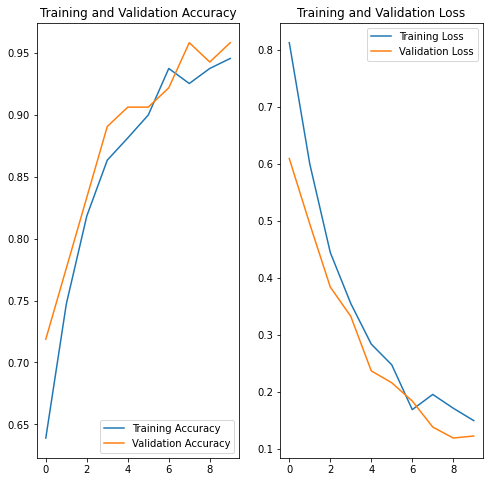

In [63]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
##Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 644ms/step
predicted label: Potato___Late_blight


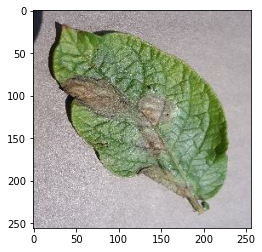

In [65]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [66]:
#Write a function for inference

In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [68]:
##Now run inference on few sample images

1/1 [==============================] - 0s 44ms/step


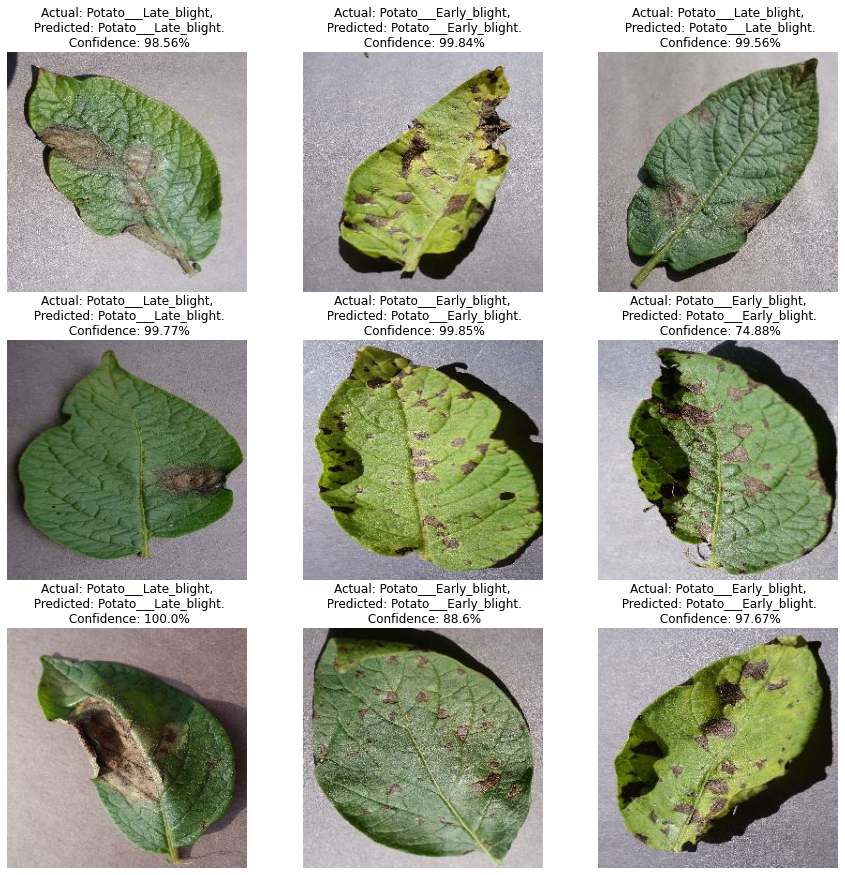

In [69]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [70]:
##Saving the Model

In [76]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [77]:
model.save("../potatoes.h5")